In [5]:
from igraph import Graph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import csv
from matplotlib import rc
# Open the GraphML file and create a Graph object from it
graph = Graph.Read_GraphML("Datas/networks/grafo_Peso_Geral.GraphML")
min_cases = list(range(1, 61))
boolQ= True
# Initialize lists to store average similarity values for each column
degrees_integral = []
betweenness_integral = []
clustering_integral = []
strength_integral = []
closeness_w_integral = []
eignv_w_integral = []
Random_mean_integral = []
Random_std_integral = []

degrees_avg = []
betweenness_avg = []
clustering_avg = []
strength_avg = []
closeness_w_avg = []
eignv_w_avg = []

C:\Users\romul\AppData\Local\Temp\ipykernel_16856\3617758968.py:10: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:492
  graph = Graph.Read_GraphML("Datas/networks/grafo_Peso_Geral.GraphML")


In [6]:

# Used to transform vertex data from 'graph' into a matrix
def get_matrix():
    # Get vertex information
    # Calculate the inverse of edge weights and store them in the 'w_inv' property
    graph.es['w_inv'] = 1.0 / np.array(graph.es['weight'])
    vertex_info = []
    geocodes = graph.vs["geocode"]
    degrees = graph.degree()
    betweenness = graph.betweenness(vertices=None, directed=False, cutoff=None, weights='w_inv')
    clustering = graph.transitivity_local_undirected()
    strength = graph.strength(weights="weight")
    closeness_w = graph.closeness(vertices=None, mode='all', cutoff=None, weights='w_inv', normalized=True)
    eignv_w = graph.evcent(directed=False, scale=True, weights='w_inv', return_eigenvalue=False)
    #prank_w = nx.pagerank(g_nx, alpha=0.85, weight='weight')
    #vuln_w = vn.vulnerability(graph, weights='w_inv')
    geocodes_int = list(map(int, geocodes))
    geocodes_strings = list(map(str,geocodes_int))
    # Construct the vertex information matrix
    vertex_info = list(zip(geocodes_strings, degrees, betweenness, clustering, strength, closeness_w, eignv_w))

    return vertex_info

# Filter cases from a CSV file based on a minimum number of cases
# and return a list of filtered elements and their data
def filter_cases(csv_file, n):
    # Read the CSV file and define the columns to be considered
    df = pd.read_csv(
        csv_file,
        encoding='utf-8',
        sep=',',
        usecols=['ibgeID', 'newCases', 'totalCases', 'date'],
        dtype={'ibgeID': int}  # Define the appropriate data type for ibgeID if possible
    )
    # Filter records that meet the requirements
    filtered_df = df[(df['totalCases'] >= n) & (df['newCases'] >= 1) & (df['ibgeID'] != 0) & (df['ibgeID'] > 1000)]
    # Remove duplicate records based on ibgeID
    filtered_df = filtered_df.drop_duplicates(subset='ibgeID')
    # Return the results as a list of tuples
    filtered_cases = list(zip(filtered_df['date'], filtered_df['ibgeID'].apply(repr)))
    return filtered_cases

def setUp_comparsion_table(cases):
# Set up the comparison matrix
    comparison_matrix = np.array([Id_matrix_covid, degrees_similarity, betweenness_similarity, clustering_similarity,
                              strength_similarity, closeness_w_similarity, eignv_w_similarity])
    Table_Names = ["DATES", "degrees", "betweenness", "clustering", "strength", "closeness_w", "eignv_w"]
    Final_Table = pd.DataFrame(comparison_matrix.T, columns=Table_Names)
# Save the final table to an Excel file
    excel_name = f"Datas/results/results_tables/result_table-{cases}cases.xlsx"
    Final_Table.to_excel(excel_name, index=False)
    
# Filter records from list A based on a filtered list of cities with more than N Covid cases
def filter_records(list_A, list_B): 
    # Create sets of geocodes for easy verification
    geocode_set_A = set(record[0] for record in list_A)
    geocode_set_B = set(record[1] for record in list_B)
    # Find geocodes that exist in both sets
    common_geocodes = geocode_set_A.intersection(geocode_set_B)
    # Filter records that meet the criteria
    filtered_list = [record for record in list_A if record[0] in common_geocodes]
    return filtered_list

def filter_records2(list_A, list_B):
    # Create a set of all geocodes in list A for easy verification
    geocode_set_A = set(record[0] for record in list_A)
    # Filter records in list B that meet the criteria
    filtered_list = [record for record in list_B if record[1] in geocode_set_A]    
    return filtered_list
# Verify the similarity between an ordered list of cities based on a certain metric
# and the list of cities with B Covid cases over time
#SE EU ORDENAR VAI DAR O MESMO QUE O CASO NORMAL 
def compare_random(metrics_matrix):
    # Select the columns from the matrices
    result = []
    for i in range(1, matrix_size + 1):
        col1_elements = set(Id_matrix_covid[:i])
        col2_elements = set(metrics_matrix[:i, 0].astype(float))
        intersection = col1_elements.intersection(col2_elements)
        similarity_percentage = (len(intersection) / len(col1_elements))
        result.append(similarity_percentage)
    return result

def compare_columns(metrics_matrix, col_idx):
    # Select the columns from the matrices
    result = []
    aux = metrics_matrix[metrics_matrix[:, col_idx].argsort()[::-1]]
   
    for i in range(1, matrix_size + 1):
        col1_elements = set(Id_matrix_covid[:i])

        col2_elements = set(aux[:i, 0].astype(float))
        intersection = col1_elements.intersection(col2_elements)
        similarity_percentage = (len(intersection) / len(col1_elements))
      
        result.append(similarity_percentage)
    return result

def calculate_random_metric_averages(data_matrix):
    
    Mselected_data = data_matrix.copy()
    # Extraia a segunda coluna (coluna 'geocode')
    # Embaralhe a lista de geocodes
    for _ in range(10):
        np.random.shuffle(Mselected_data)
    # Atualize a segunda coluna com os geocodes embaralhados
    similarity = compare_random(Mselected_data)
    result_data = {
        "Similarity": similarity}
    result_date_df = pd.DataFrame(result_data)
    result_date_df['id'] = range(1, len(result_date_df) + 1)
    excel_name = "random_metric_averages.xlsx"
    result_date_df.to_excel(excel_name, index=False)
    return result_date_df

In [7]:
def graph_plot_DateXMetrics(step,cases,leng):
    mean_table = combined_table.groupby('id').mean()
    std_table = combined_table.groupby('id').std()
    upper_bound = mean_table + 2 * std_table
    lower_bound = mean_table - 2 * std_table
    # Indices for points along the x-axis intervals
    point_indices = np.linspace(0, len(matrix_covid_dates)-1, num=100)
    date_indices = np.arange(len(matrix_covid_dates))
    # Interpolation of similarity points
    degrees_interp = np.interp(point_indices, date_indices, degrees_similarity)
    betweenness_interp = np.interp(point_indices, date_indices, betweenness_similarity)
    clustering_interp = np.interp(point_indices, date_indices, clustering_similarity)
    strength_interp = np.interp(point_indices, date_indices, strength_similarity)
    closeness_w_interp = np.interp(point_indices, date_indices, closeness_w_similarity)
    eignv_w_interp = np.interp(point_indices, date_indices, eignv_w_similarity)
    # Store the interpolation data in a pandas DataFrame
    interp_data_df = pd.DataFrame({
    'Degree': degrees_interp,
    'Weighted Betweenness': betweenness_interp,
    'Clustering': clustering_interp,
    'Weighted Strength': strength_interp,
    'Weighted Closeness': closeness_w_interp,
    'Weighted Eigenvector': eignv_w_interp })

    # Configure the plot
    plt.figure(figsize=(10, 8))
    plt.plot(point_indices, degrees_interp, 'ro-', label='Degree', marker='s')
    plt.plot(point_indices, betweenness_interp, 'go-', label='Weighted Betweenness', marker='^')
    plt.plot(point_indices, clustering_interp, 'yo-', label='Clustering', marker='v')
    plt.plot(point_indices, strength_interp, 'mo-', label='Weighted Strength', marker='x')
    plt.plot(point_indices, closeness_w_interp, 'co-', label=' Weighted Closeness ', marker='+')
    plt.plot(point_indices, eignv_w_interp, 'ko-', label='Weighted Eigenvector ',marker='o')
    plt.fill_between(mean_table.index, lower_bound['Similarity'], upper_bound['Similarity'], color='gray', alpha=0.3)
    plt.fill_between([], [], [], color='gray', alpha=0.3, label='Development with Random Cases')
    plt.text(0.5, 0.93, f'Number of Cities: {leng}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
  
    plt.legend()
    
    # Adjust the display of the x-axis
    visible_indices = np.arange(0, len(matrix_covid_dates), step=step)
    visible_dates = matrix_covid_dates[visible_indices]
    plt.tight_layout()
    plt.xticks(visible_indices, visible_dates, rotation=60)
    # Configure the plot title and axis labels
    plt.autoscale(axis='x', tight=True)
    plt.autoscale(axis='y', tight=True)
    plt.xlabel('Date')
    plt.ylabel('Similarity')
    # Display the legend
    plt.legend()
    
    plt.savefig(f'Datas/results/Collection100_{cases}cases.pdf')
    # Display the plot
    plt.show()
    plt.close()
    
    

def graph_plot_minimum_casesXMedia():
    # # List of plot styles for different measures
    # shapes = ['ro-', 'go-', 'yo-', 'mo-', 'co-', 'ko-']

    # # Set up the plot figure
    # plt.figure(figsize=(10, 6))
    # # Labels for the measures
    # labels = ['Degrees', 'Betweenness', 'Clustering', 'Strength', ' Weighted Closeness ', ' Weighted Eigenvector ']
    # # Data for each measure
    # data = [degrees_avg, betweenness_avg, clustering_avg, strength_avg, closeness_w_avg, eignv_w_avg]
    # # Ensure min_cases has the same length as each values array
    # min_cases_expanded = [min_cases] * len(data)
    # # Iterate over measures, plot the data, and add labels
    # for label, values, shape, min_cases_values in zip(labels, data, shapes, min_cases_expanded):
    #     plt.plot(min_cases_values, values, shape, label=f'Avg: {round(sum(values) / len(values), 2)} - {label}')
    #     # Add text annotations for each point
    #     for x, y in zip(min_cases_values, values):
    #         plt.text(x, y, str(round(y, 2)), ha='center', va='bottom')
    # # Set axis labels
    # plt.xlabel('Minimum number of cases')
    # plt.ylabel('Average Similarity')
    # # Automatically adjust the plot to remove empty space after data
    # plt.autoscale(axis='x', tight=True)
    # # Add legend
    # plt.legend(title='Average Similarity', loc='best')
    # # Adjust layout
    # plt.tight_layout()
    # # Save the plot as an image file
    # plt.savefig('Datas/results/graph_minimum-Media.pdf')
    # # Close the plot to release resources
    # plt.close()
    
    
    plt.figure(figsize=(10, 6))
    labels = ['Degrees', 'Weighted Betweenness', 'Clustering', 'Weighted Strength', ' Weighted Closeness ', ' Weighted Eigenvector', 'R-Mean', 'R-std']
    data = [degrees_integral, betweenness_integral, clustering_integral, strength_integral, closeness_w_integral, eignv_w_integral,Random_mean_integral,Random_std_integral]
    with open('Datas/results/table_Integral_Collection_Comparison.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Minimum number of cases'] + labels)
        
        for min_case, values in zip(min_cases, zip(*data)):
            writer.writerow([min_case] + list(values))
    print("FEito")

FEito


C:\Users\romul\AppData\Local\Temp\ipykernel_16856\865223196.py:27: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(point_indices, degrees_interp, 'ro-', label='Degree', marker='s')
C:\Users\romul\AppData\Local\Temp\ipykernel_16856\865223196.py:28: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(point_indices, betweenness_interp, 'go-', label='Weighted Betweenness', marker='^')
C:\Users\romul\AppData\Local\Temp\ipykernel_16856\865223196.py:29: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "yo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(point_indices, clustering_interp, 'yo-', label='Clustering', marker='v')
C:\Users\romul\AppData\Local\Temp\ipykernel_16856\865223196.

<Figure size 1000x600 with 0 Axes>

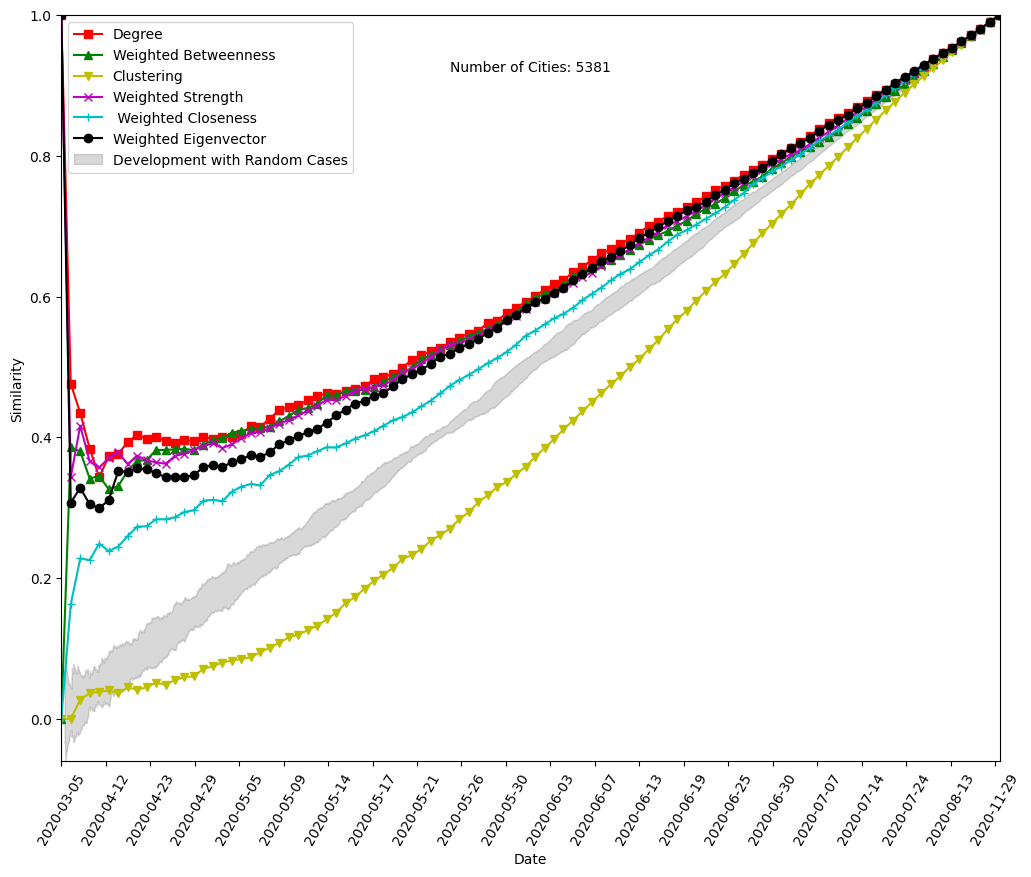

In [10]:

if len(min_cases)>1:
    for minimum_cases in min_cases:
        covidID_list = filter_cases("Datas/Pre-processed/cases-brazil-cities-time_2020.csv", minimum_cases)
        metrics_list = filter_records(get_matrix(), covidID_list)
        covidID_list = filter_records2(metrics_list,covidID_list)
        metrics_matrix = np.array(metrics_list, dtype=float)
        covid_matrix = np.array(covidID_list)
        # Receive the size of the metrics matrix to match the size of the matrices
        matrix_size = len(metrics_matrix)
        matrix_covid_dates = covid_matrix[:matrix_size, 0]
        Id_matrix_covid = covid_matrix[:matrix_size, 1].astype(float)
        result_list = [calculate_random_metric_averages(metrics_matrix) for _ in range(500)]
        combined_table = pd.concat(result_list)
        mean_table = combined_table.groupby('id').mean()
        std_table = combined_table.groupby('id').std()
        # Calculate the similarity percentage for each metric
        degrees_similarity = compare_columns(metrics_matrix, 1)
        betweenness_similarity = compare_columns(metrics_matrix, 2)
        clustering_similarity = compare_columns(metrics_matrix, 3)
        strength_similarity = compare_columns(metrics_matrix, 4)
        closeness_w_similarity = compare_columns(metrics_matrix, 5)
        eignv_w_similarity = compare_columns(metrics_matrix, 6)
        #Calculate the accumulated area under each curve
        degrees_integral.append(np.trapz(degrees_similarity, dx=1))
        betweenness_integral.append(np.trapz(betweenness_similarity, dx=1))
        clustering_integral.append(np.trapz(clustering_similarity, dx=1))
        strength_integral.append(np.trapz(strength_similarity, dx=1))
        closeness_w_integral.append(np.trapz(closeness_w_similarity, dx=1))
        eignv_w_integral.append(np.trapz(eignv_w_similarity, dx=1))
        Random_mean_integral.append(np.trapz(mean_table,dx=1))
        Random_std_integral.append(np.trapz(std_table,dx=1))
       # Calculate average similarity values for each column
        # degrees_avg.append(np.mean(degrees_similarity))
        # betweenness_avg.append(np.mean(betweenness_similarity))
        # clustering_avg.append(np.mean(clustering_similarity))
        # strength_avg.append(np.mean(strength_similarity))
        # closeness_w_avg.append(np.mean(closeness_w_similarity))
        # eignv_w_avg.append(np.mean(eignv_w_similarity))
    graph_plot_minimum_casesXMedia()
else:
    # Receive lists with filtered IDs
    covidID_list = filter_cases("Datas/Pre-processed/cases-brazil-cities-time_2020.csv", min_cases[0])
    metrics_list = filter_records(get_matrix(), covidID_list)
    covidID_list = filter_records2(metrics_list,covidID_list)
    metrics_matrix = np.array(metrics_list, dtype=float)
    covid_matrix = np.array(covidID_list)
    #Receive the size of the metrics matrix to match the size of the matrices
    matrix_size = len(metrics_matrix)
    #matrix_size = 10
    matrix_covid_dates = covid_matrix[:matrix_size, 0]
    Id_matrix_covid = covid_matrix[:matrix_size, 1].astype(float)
    result_list = [calculate_random_metric_averages(Id_matrix_covid) for _ in range(400)]
    combined_table = pd.concat(result_list)
    # Calculate the similarity percentage for each metric
    degrees_similarity = compare_columns(metrics_matrix, 1)
    betweenness_similarity = compare_columns(metrics_matrix, 2)
    clustering_similarity = compare_columns(metrics_matrix, 3)
    strength_similarity = compare_columns(metrics_matrix, 4)
    closeness_w_similarity = compare_columns(metrics_matrix, 5)
    eignv_w_similarity = compare_columns(metrics_matrix, 6)
#graph_plot_DateXMetrics(255,min_cases[0],matrix_size)
#setUp_comparsion_table(min_cases[0])
#print(degrees_similarity)